In [5]:
!pip3 install matplotlib
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 4.2 MB/s eta 0:00:01
  Using cached pandas-2.2.2-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
!pip3 install scipy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 30.3 MB 7.1 MB/s eta 0:00:01     |██████████████████████████▋     | 25.2 MB 4.7 MB/s eta 0:00:02
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy

## Original figure

In [9]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = [8.0,6.0]

In [10]:
from scipy.stats import multivariate_normal

In [11]:
# Randomize mutations and positions
def get_positions(habitat, n_muts=15, mean_copies=20):
    copies = np.random.poisson(mean_copies, size=n_muts)
    centers = np.random.uniform(*habitat, size=(n_muts,2))
    positions = [np.random.multivariate_normal(centers[i],[[1,0],[0,1]], size=copies[i]) for i in range(n_muts)]
    return positions

In [12]:
def plot_filtered(ax, positions, rv, effort):
    for i, pos in enumerate(positions):
        color = f"C{i}"
        u = np.random.rand(len(pos))
        p = effort * rv.pdf(pos)
        sampled = u < p
        ax.scatter(pos[~sampled,0], pos[~sampled,1], alpha=0.1, color=color,s=15)
        ax.scatter(pos[sampled,0], pos[sampled,1], color=color,s=15)
    return ax

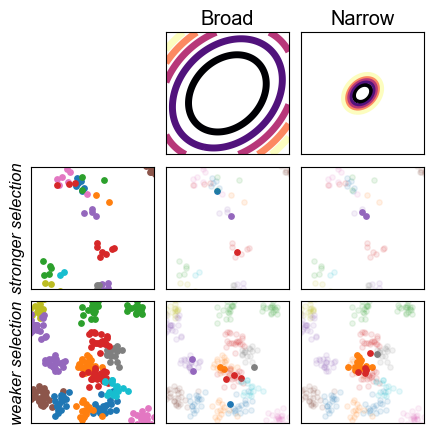

In [13]:
# for seed in range(100,120):
#     print(seed)
# import time
# seed = int(time.time())
# print(seed)

seed = 1696898790
np.random.seed(seed)
habitat = (-10, 10)

# Generate random mutations and their locations
positions1 = get_positions(habitat,mean_copies=5,n_muts=15)
positions2 = get_positions(habitat)

l = 100
x = np.linspace(*habitat, l)
y = np.linspace(*habitat, l)
ρ = 0.25

effort = 15

scale1 = 20
effort1 = effort
rv1 = multivariate_normal(cov=np.array([[1,ρ],[ρ,1]])*scale1)
#     print(effort1 * rv1.pdf([0,0]))
density1 = rv1.pdf([[a,b] for a in x for b in y]).reshape((l, l))

scale2 = 1
effort2 = effort
rv2 = multivariate_normal(cov=np.array([[1,ρ],[ρ,1]])*scale2)
#     print(effort2 * rv2.pdf([0,0]))
density2 = rv2.pdf([[a,b] for a in x for b in y]).reshape((l, l))

# Make figure

fig = plt.figure(figsize=(4.5,4.5))

ax = fig.add_subplot(332)
ax.contour(x, y, -np.log(density1) + np.log(rv1.pdf([0,0])), levels=[1,2,3,4,5], cmap='magma',linewidths=5)
ax.set_title('Broad')

ax = fig.add_subplot(333)
ax.contour(x, y, -np.log(density2) + np.log(rv2.pdf([0,0])), levels=[1,2,3,4,5], cmap='magma')
ax.set_title('Narrow')

# First replicate

ax = fig.add_subplot(334)
for pos in positions1:
    ax.scatter(pos[:,0], pos[:,1],s=15)
ax.set_ylabel("stronger selection",fontstyle='italic')
    
# ax.set_title('All variants')
    
ax = fig.add_subplot(335)
plot_filtered(ax, positions1, rv1, effort1)

ax = fig.add_subplot(336)
plot_filtered(ax, positions1, rv2, effort2)

# Second replicate

ax = fig.add_subplot(337)
for pos in positions2:
    ax.scatter(pos[:,0], pos[:,1],s=15)
ax.set_ylabel("weaker selection",fontstyle='italic')
# ax.set_title('All variants')
    
ax = fig.add_subplot(338)
plot_filtered(ax, positions2, rv1, effort1)

ax = fig.add_subplot(339)
plot_filtered(ax, positions2, rv2, effort2)

for ax in fig.get_axes():
    ax.set_ylim(habitat)
    ax.set_xlim(habitat)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
fig.subplots_adjust(wspace=0.1,hspace=0.1)
# plt.savefig("broadnarrow_schematic.pdf")
plt.show()
#seed 1696898790 to get figure used in current draft

58


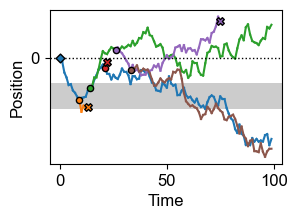

In [14]:

def branching_diffusion_with_death(num_particles, steps, branch_prob, death_prob, diff_std, max_particles=10,
                                  smin=-10,smax=-5):
#     max_particles = steps * num_particles
    
    # Initialize arrays
    positions = np.zeros((steps, max_particles))
    alive = np.zeros((steps, max_particles), dtype=bool)
    colors = [f"C{i%10}" for i in range(max_particles)]
    
    alive[0, 0] = True

    live_counts = np.zeros(steps)  # Array to hold counts of live particles at each time step
    live_counts[0] = 1
    
    live_counts_samp = np.zeros(steps)
    if smin <= 0 <= smax:
        live_counts_samp[0] = 1

    
    births = []  # To store birth events
    deaths = []  # To store death events

    for step in range(1, steps):
        for i in range(num_particles):
            if not alive[step-1, i]:
                continue

            # Diffusion
            move = np.random.normal(0, diff_std)
            positions[step, i] = positions[step-1, i] + move

            # Death process
            if np.random.rand() < death_prob:
                deaths.append((step-1, positions[step-1, i], colors[i]))  # Record death event with the current position
                continue
            else:
                alive[step, i] = True  # If not dead, mark the particle as alive

            # Branching
            if np.random.rand() < branch_prob and num_particles < max_particles:
                num_particles += 1
                positions[step, num_particles-1] = positions[step, i]
                alive[step, num_particles-1] = True
                births.append((step, positions[step, i], colors[num_particles-1]))  # Record birth event

        live_counts[step] = np.sum(alive[step, :])
        
        for i in range(num_particles):
            if alive[step, i] and smin <= positions[step, i] <= smax:
                live_counts_samp[step] += 1
        
    return positions, alive, colors, births, deaths, live_counts, live_counts_samp

# Parameters
num_particles = 1
steps = 100
branch_prob = 0.02
death_prob = 0.02
diff_std = 1.0
# seed = random.randint(1,100)
seed = 58
smin = -10
smax = -5
np.random.seed(seed)
print(seed)
positions, alive, colors, births, deaths, live_counts, live_counts_sample = branching_diffusion_with_death(num_particles, 
                                                                          steps, branch_prob, 
                                                                          death_prob, diff_std,
                                                                          max_particles=6, smin = smin,
                                                                          smax = smax)

plt.figure(figsize=(3, 2))

plt.axhspan(-10,-5,facecolor='gray',alpha=0.4,edgecolor='none')

for i in range(positions.shape[1]):
    alive_indices = np.where(alive[:, i])[0]
    if alive_indices.any():
        for j in range(len(alive_indices)-1):
            if alive_indices[j+1] - alive_indices[j] == 1:
                plt.plot(range(alive_indices[j], alive_indices[j+1]+1), 
                         positions[alive_indices[j]:alive_indices[j+1]+1, i], 
                         color=colors[i],linewidth=1.5)

# Add markers for births and deaths
for birth in births:
    plt.scatter(birth[0], birth[1], c=birth[2], marker='o',s=20,zorder=3,edgecolors='black')

for death in deaths:
    plt.scatter(death[0], death[1], c=death[2], marker='X',s=30,zorder=3,edgecolors='black')


plt.scatter(0, 0, marker='D', color=colors[0], s=20, zorder=3,edgecolors='black')  

# plt.title("Branching Diffusion with Death Process")
plt.xlabel("Time")
plt.ylabel("Position")
plt.yticks([0])
plt.axhline(y=0,linestyle='dotted',linewidth=1,color='black')
# plt.grid(True)

plt.show()
# plt.legend()
# plt.savefig("branching_process_schematic.pdf")

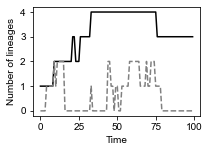

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(live_counts)),live_counts,color='black',label="Entire habitat",linewidth=1.5)
plt.plot(range(len(live_counts)),live_counts_sample,linestyle='dashed',color='gray',label="Sampled region",linewidth=1.5)
plt.xlabel("Time")
plt.ylabel("Number of lineages")
# plt.legend()
plt.yticks([0,1,2,3,4])
plt.savefig("branching_process_schematic_counts.pdf")

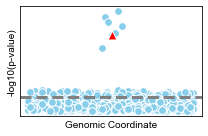

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Fake data generation
chromosome_length = 100
num_chromosomes = 23

# Generating random genomic coordinates and p-values
x = np.random.randint(0, chromosome_length, num_chromosomes * 100)
y = -np.log10(np.random.uniform(0.01, 1, num_chromosomes * 100))

# Introducing one significant hit
primary_hit_index = 50
x[primary_hit_index] = chromosome_length / 2
y[primary_hit_index] = -np.log10(1e-10)

# Introducing linked hits around the significant one
linked_hit_indices = range(primary_hit_index - 3, primary_hit_index + 4)  # 3 on each side
for i in linked_hit_indices:
    x[i] = x[primary_hit_index] + (i - primary_hit_index) * 2  # spacing linked sites
    y[i] = -np.log10(1e-8) + np.random.uniform(-2, 2)  # randomize a bit around main hit

# Plotting
plt.figure(figsize=(3, 2))
plt.scatter(x, y, c='skyblue', edgecolors='w', s=60)
plt.scatter(x[primary_hit_index], y[primary_hit_index], c='red', marker='^', edgecolors='w', s=80)  # significant hit as red triangle
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--')  # significance threshold

# Styling
plt.xlabel('Genomic Coordinate')
plt.ylabel('-log10(p-value)')
# plt.title('Manhattan Plot')

# Remove x and y ticks but keep labels
plt.xticks(ticks=[])
plt.yticks(ticks=[])

plt.tight_layout()
# plt.show()
plt.savefig("ex_manhattan.pdf")